# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [54]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [12]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 14, 19, 22, 59, 412128)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [13]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1161369
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [14]:
feature_view = fs.get_feature_view(
    name='air_quality_fv_new',
    version=1,
)

AttributeError: 'FeatureView' object has no attribute 'read'

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [15]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_new",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [16]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.319588E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [34]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
weather_data = weather_fg.filter(weather_fg.date >= today).read()

# Ensure the 'date' column is in datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Sort the weather data by the 'date' column
weather_data.sort_values(by='date', inplace=True)
weather_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2,2024-11-15 00:00:00+00:00,8.80,0.0,8.217153,298.810699,bondville
1,2024-11-16 00:00:00+00:00,4.40,0.0,7.653705,131.185822,bondville
0,2024-11-17 00:00:00+00:00,9.00,0.0,14.182355,203.962494,bondville
6,2024-11-18 00:00:00+00:00,9.00,0.0,9.957108,49.398785,bondville
5,2024-11-19 00:00:00+00:00,14.10,0.3,26.208397,142.815216,bondville
4,2024-11-20 00:00:00+00:00,7.00,0.0,6.369050,317.290619,bondville
3,2024-11-21 00:00:00+00:00,10.05,0.2,22.545315,70.407631,bondville
8,2024-11-22 00:00:00+00:00,6.40,0.0,22.565422,213.943634,bondville
7,2024-11-23 00:00:00+00:00,4.15,0.0,10.661107,258.310669,bondville


In [28]:
# Get the batch data from the feature view
featureview_data = feature_view.get_batch_data()
featureview_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.57s) 


,rolling_mean_pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,53.000000,2015-01-29 00:00:00+00:00,2.778666,0.9,31.981293,242.330261,bondville
1,42.333333,2015-01-30 00:00:00+00:00,-0.829667,0.0,22.864960,322.465088,bondville
2,42.666667,2015-01-31 00:00:00+00:00,-1.423417,0.2,15.815435,216.009201,bondville
3,38.333333,2015-02-01 00:00:00+00:00,0.130750,18.5,19.694992,138.588654,bondville
4,40.333333,2015-02-02 00:00:00+00:00,-9.569249,1.3,28.533264,323.583527,bondville
...,...,...,...,...,...,...,...
3363,19.333333,2024-11-05 00:00:00+00:00,18.549999,40.0,33.481937,182.901917,bondville
3364,16.000000,2024-11-06 00:00:00+00:00,14.093749,0.6,20.531050,272.000244,bondville
3365,16.000000,2024-11-06 00:00:00+00:00,14.093749,0.6,20.531050,272.000244,bondville
3366,20.666667,2024-11-08 00:00:00+00:00,3.800000,0.0,7.289445,327.094757,bondville


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [35]:
last_rolling_mean = featureview_data['rolling_mean_pm25'].iloc[-1]

# Iterate over each day in the future weather data
for i, row in weather_data.iterrows():
    # Prepare the input data for prediction
    input_data = pd.DataFrame({
        'rolling_mean_pm25': [last_rolling_mean],
        'temperature_2m_mean': [row['temperature_2m_mean']],
        'precipitation_sum': [row['precipitation_sum']],
        'wind_speed_10m_max': [row['wind_speed_10m_max']],
        'wind_direction_10m_dominant': [row['wind_direction_10m_dominant']]
    })
    
    # Make the prediction
    predicted_pm25 = retrieved_xgboost_model.predict(input_data)[0]
    
    # Calculate the new rolling mean
    new_rolling_mean = (last_rolling_mean * 2 + predicted_pm25) / 3
    
    # Update the weather_data DataFrame with the predictions
    weather_data.at[i, 'predicted_pm25'] = predicted_pm25
    weather_data.at[i, 'predicted_rolling_mean_pm25'] = new_rolling_mean
    
    # Update the last rolling mean for the next iteration
    last_rolling_mean = new_rolling_mean

# Display the updated weather_data DataFrame
weather_data
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['rolling_mean_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,predicted_rolling_mean_pm25
2,2024-11-15 00:00:00+00:00,8.80,0.0,8.217153,298.810699,bondville,34.406292,35.468764
1,2024-11-16 00:00:00+00:00,4.40,0.0,7.653705,131.185822,bondville,37.678047,36.205192
0,2024-11-17 00:00:00+00:00,9.00,0.0,14.182355,203.962494,bondville,38.842770,37.084384
6,2024-11-18 00:00:00+00:00,9.00,0.0,9.957108,49.398785,bondville,41.568588,38.579119
5,2024-11-19 00:00:00+00:00,14.10,0.3,26.208397,142.815216,bondville,42.581459,39.913232
4,2024-11-20 00:00:00+00:00,7.00,0.0,6.369050,317.290619,bondville,37.024891,38.950452
3,2024-11-21 00:00:00+00:00,10.05,0.2,22.545315,70.407631,bondville,43.272396,40.391100
8,2024-11-22 00:00:00+00:00,6.40,0.0,22.565422,213.943634,bondville,41.047569,40.609923
7,2024-11-23 00:00:00+00:00,4.15,0.0,10.661107,258.310669,bondville,44.096550,41.772132


In [36]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 2 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float64            
 7   predicted_rolling_mean_pm25  9 non-null      float64            
dtypes: datetime64[ns, UTC](1), float32(4), float64(2), object(1)
memory usage: 804.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [37]:
weather_data['street'] = street
weather_data['city'] = city
weather_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
weather_data['days_before_forecast_day'] = range(1, len(weather_data)+1)
# weather_data = weather_data.sort_values(by=['date'])
weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,predicted_rolling_mean_pm25,street,country,days_before_forecast_day
2,2024-11-15 00:00:00+00:00,8.80,0.0,8.217153,298.810699,bondville,34.406292,35.468764,bondville-illinois-usa,usa,1
1,2024-11-16 00:00:00+00:00,4.40,0.0,7.653705,131.185822,bondville,37.678047,36.205192,bondville-illinois-usa,usa,2
0,2024-11-17 00:00:00+00:00,9.00,0.0,14.182355,203.962494,bondville,38.842770,37.084384,bondville-illinois-usa,usa,3
6,2024-11-18 00:00:00+00:00,9.00,0.0,9.957108,49.398785,bondville,41.568588,38.579119,bondville-illinois-usa,usa,4
5,2024-11-19 00:00:00+00:00,14.10,0.3,26.208397,142.815216,bondville,42.581459,39.913232,bondville-illinois-usa,usa,5
4,2024-11-20 00:00:00+00:00,7.00,0.0,6.369050,317.290619,bondville,37.024891,38.950452,bondville-illinois-usa,usa,6
3,2024-11-21 00:00:00+00:00,10.05,0.2,22.545315,70.407631,bondville,43.272396,40.391100,bondville-illinois-usa,usa,7
8,2024-11-22 00:00:00+00:00,6.40,0.0,22.565422,213.943634,bondville,41.047569,40.609923,bondville-illinois-usa,usa,8
7,2024-11-23 00:00:00+00:00,4.15,0.0,10.661107,258.310669,bondville,44.096550,41.772132,bondville-illinois-usa,usa,9


In [38]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 2 to 7
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float64            
 7   predicted_rolling_mean_pm25  9 non-null      float64            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

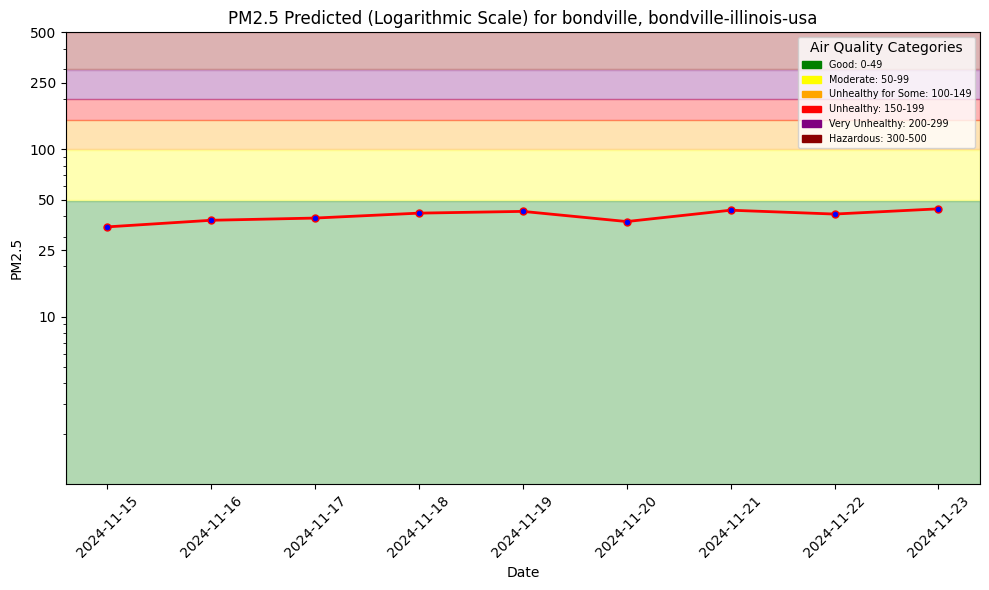

In [39]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, weather_data, file_path)
plt.show()

In [40]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_new',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [41]:
monitor_fg.insert(weather_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1161369/fs/1152072/fg/1347996


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1161369/jobs/named/aq_predictions_new_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x150212560>, None)

In [42]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,predicted_rolling_mean_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,8.8,0.0,8.217153,298.810699,bondville,34.406292,35.468764,bondville-illinois-usa,usa,1


In [43]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_new',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


,date,pm25,rolling_mean_pm25,country,city,street,url
0,2015-09-14 00:00:00+00:00,21.0,17.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
1,2019-02-27 00:00:00+00:00,55.0,41.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
2,2021-04-06 00:00:00+00:00,59.0,60.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3,2023-10-13 00:00:00+00:00,34.0,35.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
4,2016-05-01 00:00:00+00:00,27.0,34.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
...,...,...,...,...,...,...,...
3363,2019-05-25 00:00:00+00:00,30.0,34.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3364,2020-12-08 00:00:00+00:00,57.0,49.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3365,2020-09-10 00:00:00+00:00,35.0,31.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3366,2021-04-30 00:00:00+00:00,26.0,43.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638


In [58]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])


# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    pass
    # hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

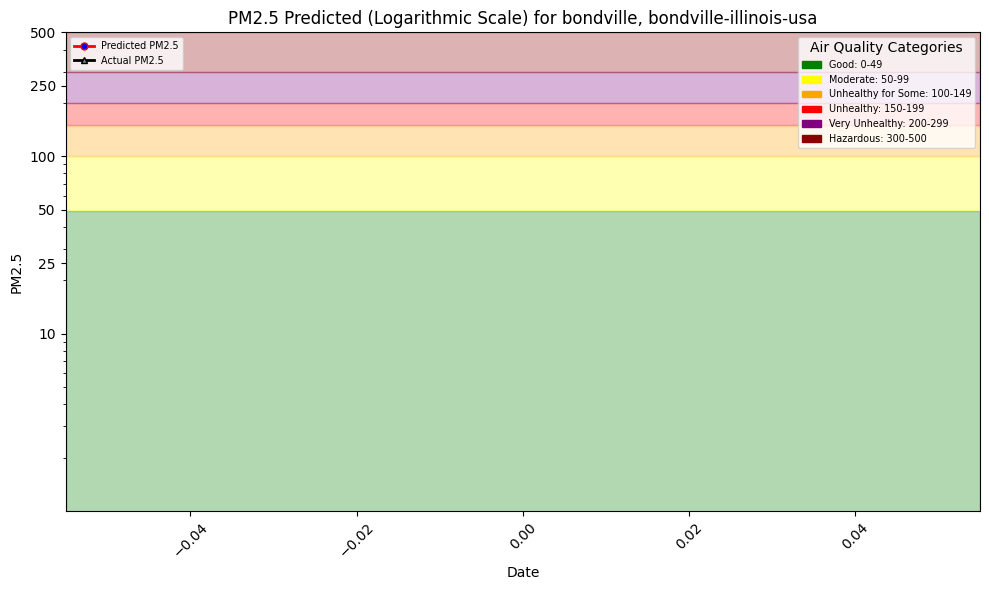

In [59]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---